In [2]:
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

from lstm_utils.utils import plot_confusion_matrix

In [3]:
ds = load_dataset('emotion')
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
model_chckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_chckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_chckpt, num_labels=6).to('cuda')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def tokenize_batch(batch, tokenizer=tokenizer):
    return tokenizer(batch['text'], padding=True, truncation=True)

ds = ds.map(tokenize_batch, batched=True, batch_size=None)
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [6]:
ds.set_format('pytorch')

In [7]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1_macro = f1_score(labels, preds, average='macro')
    f1_micro = f1_score(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'acc': acc
    }

In [8]:
train_ds = ds['train']
val_ds = ds['validation']
test_ds = ds['test']

In [9]:
batch_size = 4
logging_steps = len(train_ds) // batch_size
num_train_epochs = 10
learning_rate = 2e-5
weight_decay = 1e-5

training_args = TrainingArguments(
    output_dir=f'{model_chckpt}_emotions',
    num_train_epochs=num_train_epochs,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=weight_decay,
    evaluation_strategy='epoch',
    logging_steps=logging_steps,
    disable_tqdm=False
)

/home/cybertech/tomekg/NLP_learning/.venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer
)

trainer.train()

Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro,Acc
1,0.435900,0.316642,0.894890,0.923500,0.923500
2,0.204900,0.274860,0.913498,0.937000,0.937000
3,0.168800,0.250787,0.918207,0.941000,0.941000
4,0.115100,0.319670,0.915681,0.938000,0.938000
5,0.074100,0.415089,0.916915,0.938500,0.938500
6,0.039200,0.449640,0.917297,0.939500,0.939500
7,0.035900,0.444154,0.918953,0.943000,0.943000
8,0.021500,0.468575,0.916994,0.939000,0.939000
9,0.018000,0.440490,0.923972,0.944500,0.944500
10,0.009700,0.443114,0.926834,0.946500,0.946500


TrainOutput(global_step=40000, training_loss=0.11229702625274658, metrics={'train_runtime': 900.0105, 'train_samples_per_second': 177.776, 'train_steps_per_second': 44.444, 'total_flos': 3601714308480000.0, 'train_loss': 0.11229702625274658, 'epoch': 10.0})

In [11]:
def error_analysis(batch, 
                   model=model, 
                   loss_fun=nn.CrossEntropyLoss(reduction='none'), 
                   model_input_names=tokenizer.model_input_names, 
                   device='cuda'
                   ):
    
    inputs = {k: v.to(device) for k, v in batch.items() if k in model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        loss_vals = loss_fun(output.logits, batch['label'].to(device))
    return {'loss_value': loss_vals.cpu().numpy(), 'model_prediction': torch.argmax(output.logits, dim=1).cpu().numpy()}

In [12]:
val_ds = val_ds.map(error_analysis, batched=True, batch_size=32)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 4317.69 examples/s]


In [16]:
val_ds.set_format('pandas')

In [17]:
val_df = val_ds[:]
val_df.sort_values(by='loss_value', ascending=False)[['text', 'loss_value', 'label', 'model_prediction']].head(n=10)

,text,loss_value,label,model_prediction
1801,i feel that he was being overshadowed by the s...,15.540917,2,0
177,im sure much of the advantage is psychological...,15.455382,0,1
1032,i began to feel woeful as i stared into the ab...,14.740557,0,1
1689,i got outside i beat myself up pretty bad ment...,13.989250,4,1
944,i didn t consider that she maybe had difficult...,13.917896,2,4
415,im kind of embarrassed about feeling that way ...,13.846332,2,0
1950,i as representative of everything thats wrong ...,13.799293,5,0
860,i first had cordelia i didnt feel a strong urg...,13.679447,1,4
1919,i should admit when consuming alcohol myself i...,13.637722,4,0
1124,someone acting stupid in public,12.989058,3,0


In [18]:
val_df.sort_values(by='loss_value', ascending=True)[['text', 'loss_value', 'label', 'model_prediction']].head(n=10)

,text,loss_value,label,model_prediction
1830,i feel defeated conflicted poor lonely rejecte,0.000001,0,0
954,im feeling disheartened and have not been look...,0.000001,0,0
386,i feel so embarrassed and humiliated korean at...,0.000001,0,0
57,i just feel discouraged because the industry i...,0.000001,0,0
1376,i feel far less lonely,0.000001,0,0
189,i leave the meeting feeling more than a little...,0.000001,0,0
349,i feel so dumb photographing myself okay i eve...,0.000001,0,0
368,i have to admit that i m feeling quite gloomy ...,0.000001,0,0
26,i don t know if anybody will ever be able to f...,0.000001,0,0
257,im feeling very remorseful at the moment,0.000001,0,0


In [21]:
val_df[['label', 'loss_value']].groupby(by='label', as_index=True).mean()

,loss_value
label,
0,0.225082
1,0.312812
2,1.224991
3,0.366906
4,0.487990
5,1.479171


{'test_loss': 0.5471583604812622, 'test_f1_macro': 0.8854340309198285, 'test_f1_micro': 0.9265, 'test_acc': 0.9265, 'test_runtime': 1.102, 'test_samples_per_second': 1814.876, 'test_steps_per_second': 453.719}


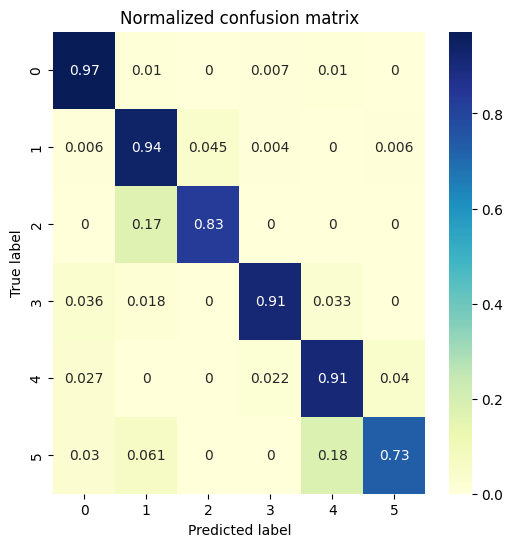

In [23]:
preds_out = trainer.predict(test_dataset=test_ds)
print(preds_out.metrics)
plot_confusion_matrix(y_true=test_ds['label'], y_pred=np.argmax(preds_out.predictions, axis=1))